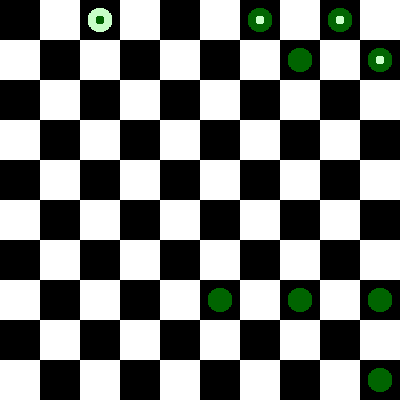

In [ ]:
from _operator import attrgetter
import math

from PIL import Image, ImageColor
import IPython.display

from Position import Position
from Piece import Piece
from Board import Board
from Game import Game
from random import random

class AlfaBetaBot:
    def __init__(self):
        self.max_depth = 5
    def heuristic_state_value(self, board):
        score = 0
        num_pieces = 0
        for white in board.whites:
            num_pieces += 1
            score += 5
            if white.king:
                score += 20
            else:
                score += white.y/25
        for black in board.blacks:
            num_pieces += 1
            score -= 5
            if black.king:
                score -= 20
            else:
                score -= black.y/25
        return score / num_pieces
    def possible_captures(self, board, king, position, captures_moves_list):
        ans = []
        if not king:
            possible_y = [1]
            if len(captures_moves_list) > 1:
                possible_y.append(-1)
            for j in possible_y:
                for i in [-1, 1]:
                    if board.isBlack(position.add(j, i)):
                        if board.isEmpty(position.add(j * 2, 2 * i)):
                            new_position = position.add(j * 2, 2 * i)
                            new_board = board.make_single_move(position, new_position, True, False)
                            captures_moves_list.append(new_position)
                            ans += [captures_moves_list.copy()]
                            ans += self.possible_captures(new_board, king, new_position, captures_moves_list)
                            captures_moves_list.pop()

        else:
            for xi in [-1, 1]:
                for yi in [-1, 1]:
                    where = position.add(yi, xi)
                    while board.isEmpty(where):
                        where = where.add(yi, xi)
                    if board.isBlack(where) and board.isEmpty(where.add(yi, xi)):
                        where = where.add(yi, xi)
                        new_position = where
                        while board.isEmpty(where):
                            ans += [captures_moves_list + [where]]
                            where = where.add(yi, xi)
                        new_board = board.make_single_move(position, new_position, True, False)
                        captures_moves_list.append(new_position)
                        ans += self.possible_captures(new_board, king, new_position, captures_moves_list)
                        captures_moves_list.pop()
        return ans

    def possible_moves(self, board):
        moves = []
        if board.capture_possible():
            for white in board.whites:
                moves += self.possible_captures(board, white.king, white.position(), [white.position()])
        else:
            for white in board.whites:
                if not white.king:
                    for i in [-1, 1]:
                        if board.isEmpty(white.position().add(1, i)):
                            moves += [[white.position(), white.position().add(1, i)]]
                else:
                    for xi in [-1, 1]:
                        for yi in [-1, 1]:
                            where = white.position().add(yi, xi)
                            while board.isEmpty(where):
                                moves += [[white.position(), where]]
                                where = where.add(yi, xi)
        return moves

    def alfa_beta_first(self, board):
        sorted_moves = [(self.heuristic_state_value(board.make_move(move)), move) for move in self.possible_moves(board)]
        sorted_moves.sort(key=lambda x: (x[0] * (-1)))
        value = -float("inf")
        res_move = []
        for (_, move) in sorted_moves:
            child_value = self.alfa_beta(board.make_move(move), 1, value)
            if child_value > value or (child_value == value and random.randint(1, 10) > 9):
                res_move = move
                value = child_value
        return res_move

    def alfa_beta(self, board, depth = 0, best = -float("inf"), worse = float("inf")):
        if depth == self.max_depth:
            return self.heuristic_state_value(board)
        if depth % 2 == 0:
            value = -float("inf")
            for move in self.possible_moves(board):
                child_value = self.alfa_beta(board.make_move(move), depth + 1, best, worse)
                best = max(best, child_value)
                value = max(value, child_value)
                if best >= worse:
                    break
        else:
            value = float("inf")
            for move in self.possible_moves(board):
                child_value = self.alfa_beta(board.make_move(move), depth + 1, best, worse)
                worse = min(worse, child_value)
                value = min(value, child_value)
                if best >= worse:
                    break
        return value
    def make_move(self, state):
        return self.alfa_beta_first(state)